In [1]:
import numpy as np
import pandas as pd

# Sample data for time series
data = [4, 5, 6, 5, 4]
df = pd.DataFrame(data, columns=['X'])

# Calculate mean
mu = df['X'].mean()

# Calculate deviations
df['Deviation'] = df['X'] - mu

# Function to calculate auto covariance for a given lag k
def auto_covariance(series, lag):
    n = len(series)
    cov = np.sum(series[:n-lag] * series[lag:]) / (n - lag)
    return cov

# Calculate auto covariance for lag 1
k = 1
gamma_k = auto_covariance(df['Deviation'].values, k)
print(f"Auto Covariance at lag {k}: {gamma_k}")

Auto Covariance at lag 1: 0.04000000000000007


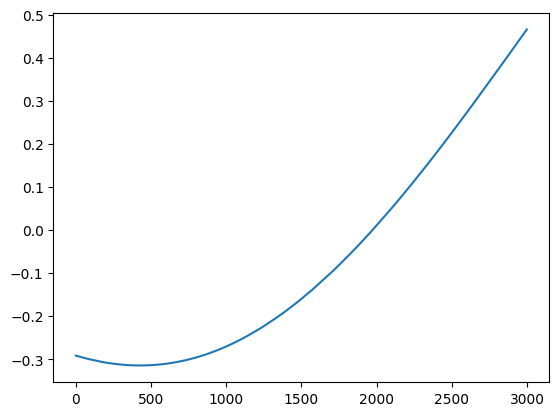

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_process_cholesky(R_tau, time_grid):
    N = len(time_grid)
    cov_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            cov_matrix[i, j] = R_tau(abs(time_grid[i] - time_grid[j]))

    L = np.linalg.cholesky(cov_matrix + 1e-10*np.eye(N))  # Add small regularization
    white_noise = np.random.randn(N)
    return L @ white_noise

t = np.linspace(0, 1, 3000)
sigma = 1
def gaussian(tau):
    return np.exp(-tau**2 / (2*sigma**2))

sig = simulate_process_cholesky(gaussian, t)

plt.plot(sig)


In [3]:
import numpy as np
from numpy.fft import fft, ifft

def gaussian_autocovariance(t, sigma=1.0, ell=1.0):
    # return 100 + sigma**2 * np.exp(-t**2 / (2 * ell**2))
    return sigma**2 * np.exp(-t**2 / (2 * ell**2))

def simulate_gaussian_process(n, dt=1.0, sigma=1.0, ell=1.0):
    """
    Simulates a stationary Gaussian process with a Gaussian autocovariance function
    using the Shinozuka-Deodatis spectral method.
    
    Parameters:
        n     : number of desired time points
        dt    : time step
        sigma : standard deviation of the process
        ell   : correlation length (controls width of the autocovariance)
    
    Returns:
        t : time vector
        x : simulated Gaussian process
    """
    m = 2 * n  # For circulant embedding

    # Time vector for autocovariance
    taus = dt * np.arange(0, m)
    R = gaussian_autocovariance(np.concatenate([taus[:n], -taus[n:]]), sigma, ell)

    # FFT to get eigenvalues (power spectrum)
    lam = np.real(fft(R))
    lam = np.maximum(lam, 0)  # Force non-negativity

    # Generate frequency domain coefficients a(j)
    a = np.zeros(m, dtype=complex)
    a[0] = np.sqrt(lam[0] / m) * np.random.randn()
    a[m//2] = np.sqrt(lam[m//2] / m) * np.random.randn()

    for j in range(1, m//2):
        Uj, Vj = np.random.randn(2)
        a[j] = (np.sqrt(lam[j] / (2*m)) * (Uj + 1j*Vj))
        a[m - j] = np.conj(a[j])  # Hermitian symmetry

    # Inverse FFT to get real-valued time-domain signal
    x_full = np.real(ifft(a))
    t = np.arange(n) * dt
    return t, x_full[:n]


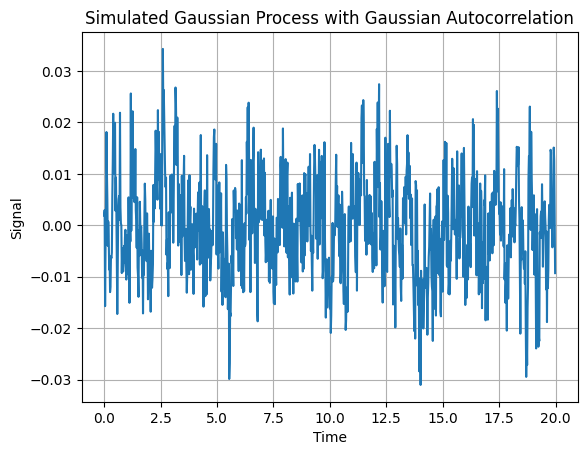

In [4]:
import matplotlib.pyplot as plt

N=1000
dt=0.02

t, x = simulate_gaussian_process(n=N, dt=dt, sigma=20.0, ell=0.08)

plt.plot(t, x)
plt.title("Simulated Gaussian Process with Gaussian Autocorrelation")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()


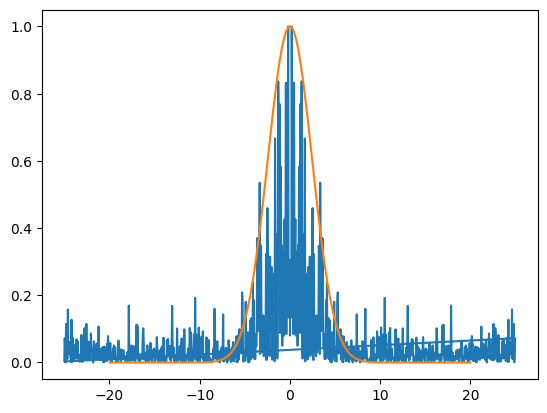

In [5]:
f = np.fft.fftfreq(N, d=dt)
x_f = np.fft.fft(x)
psd = np.abs(x_f)**2
psd = psd / np.max(psd)

f_theory = np.linspace(-20, 20, 1000)
psd_theory = np.exp(-f_theory**2 / 12)

plt.plot(f, psd)
plt.plot(f_theory, psd_theory)

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


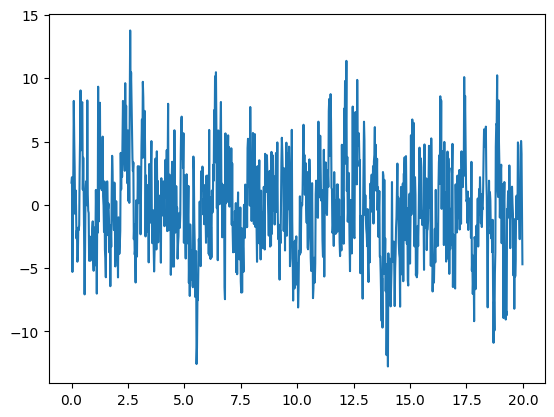

In [6]:
x_prime = 400*x + np.exp(1j*(3*t))
plt.plot(t, x_prime)

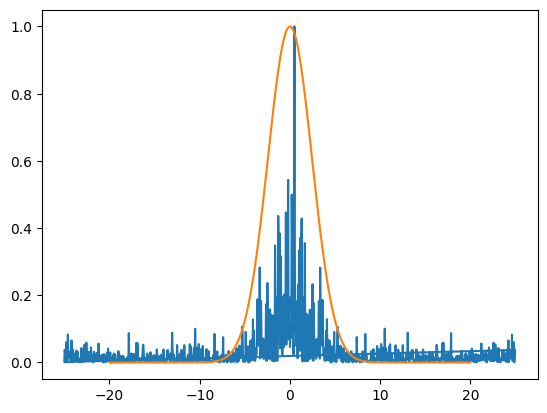

In [7]:
f = np.fft.fftfreq(N, d=dt)
x_f = np.fft.fft(x_prime)
psd = np.abs(x_f)**2
psd = psd / np.max(psd)

f_theory = np.linspace(-20, 20, 1000)
psd_theory = np.exp(-f_theory**2 / 12)

plt.plot(f, psd)
plt.plot(f_theory, psd_theory)

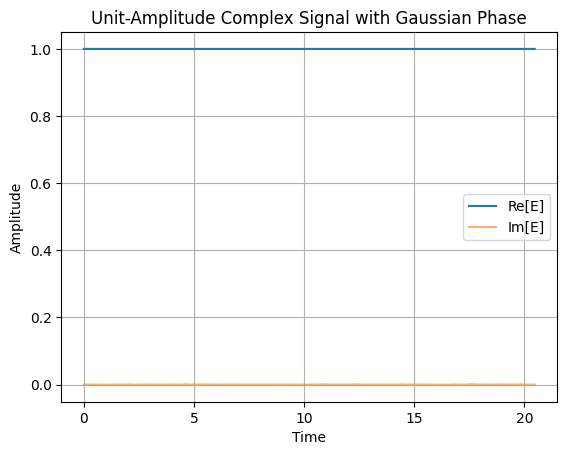

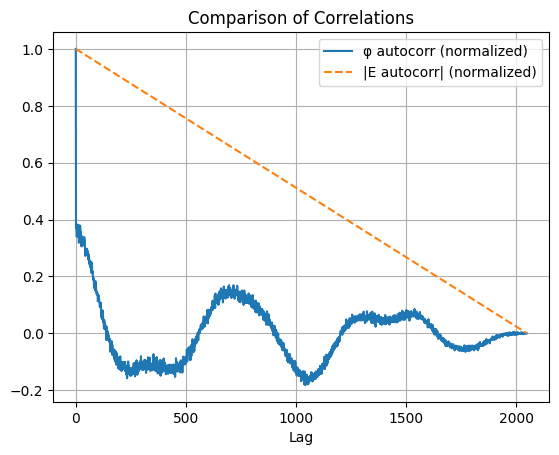

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate Gaussian process φ(t)
t, phi = simulate_gaussian_process(n=2048, dt=0.01, sigma=1.0, ell=1.0)

# Convert to complex exponential with constant amplitude
E = np.exp(1j * phi)

# Plot phase-modulated signal
plt.plot(t, np.real(E), label='Re[E]')
plt.plot(t, np.imag(E), label='Im[E]', alpha=0.6)
plt.title("Unit-Amplitude Complex Signal with Gaussian Phase")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

# Optional: check autocorrelation of E
def autocorr(x):
    n = len(x)
    return np.correlate(x, x, mode='full')[n-1:] / n

R_phi = autocorr(phi)
R_E = np.abs(autocorr(E))

plt.plot(R_phi / R_phi[0], label='φ autocorr (normalized)')
plt.plot(R_E / R_E[0], label='|E autocorr| (normalized)', linestyle='--')
plt.title("Comparison of Correlations")
plt.xlabel("Lag")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import numpy as np
from numpy.fft import fft, ifft

def gaussian_autocovariance(t, sigma=1.0, ell=1.0):
    return sigma**2 - t**2 / ell
    # return sigma**2 * np.exp(-t**2 / (2 * ell**2))

def simulate_gaussian_process(n, dt=1.0, sigma=1.0, ell=1.0):
    """
    Simulates a stationary Gaussian process with a Gaussian autocovariance function
    using the Shinozuka-Deodatis spectral method.
    
    Parameters:
        n     : number of desired time points
        dt    : time step
        sigma : standard deviation of the process
        ell   : correlation length (controls width of the autocovariance)
    
    Returns:
        t : time vector
        x : simulated Gaussian process
    """
    m = 2 * n  # For circulant embedding

    # Time vector for autocovariance
    taus = dt * np.arange(0, m)
    R = gaussian_autocovariance(np.concatenate([taus[:n], -taus[n:]]), sigma, ell)

    # FFT to get eigenvalues (power spectrum)
    lam = np.real(fft(R))
    lam = np.maximum(lam, 0)  # Force non-negativity

    # Generate frequency domain coefficients a(j)
    a = np.zeros(m, dtype=complex)
    a[0] = np.sqrt(lam[0] / m) * np.random.randn()
    a[m//2] = np.sqrt(lam[m//2] / m) * np.random.randn()

    for j in range(1, m//2):
        Uj, Vj = np.random.randn(2)
        a[j] = (np.sqrt(lam[j] / (2*m)) * (Uj + 1j*Vj))
        a[m - j] = np.conj(a[j])  # Hermitian symmetry

    # Inverse FFT to get real-valued time-domain signal
    x_full = np.real(ifft(a))
    t = np.arange(n) * dt
    return t, x_full[:n]

In [147]:
N=10000
t, phi = simulate_gaussian_process(N, dt=dt, sigma=1, ell=0.01)
x = np.exp(1j*(1*t)+np.cumsum(phi))

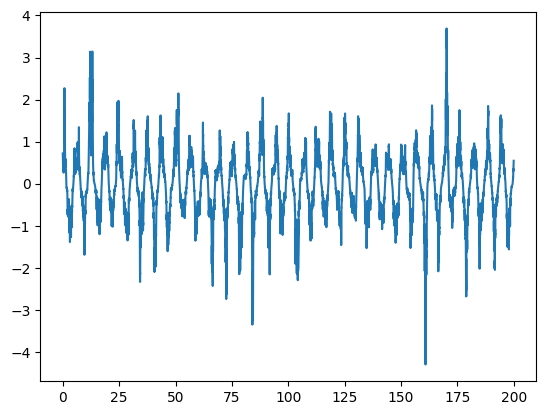

In [148]:
plt.plot(t, x)

(-0.22, 0.28)

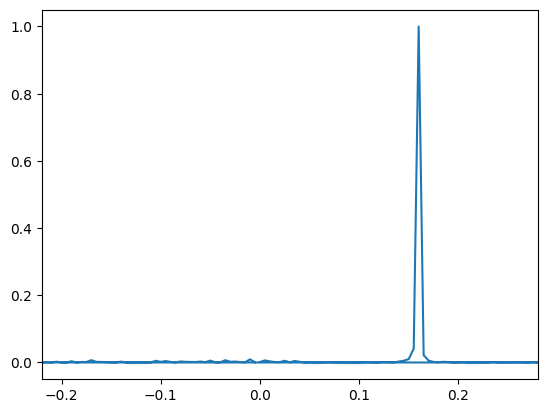

In [149]:

f = np.fft.fftfreq(N, d=dt)
x_f = np.fft.fft(x)
psd = np.abs(x_f)**2
psd = psd / np.max(psd)

f_theory = np.linspace(-20, 20, 1000)
psd_theory = np.exp(-f_theory**2 / 12)

plt.plot(f, psd)
# plt.plot(f_theory, psd_theory)
plt.xlim(-0.22, 0.28)